# **Segundo Trabalho Computacional**
TIP7077 – Inteligência Computacional Aplicada 


Mariana Marques Ferreira - 587140

Este relatório documenta o Projeto 2 – Reconhecimento de Faces, cujo objetivo é sintetizar e comparar classificadores aplicados ao conjunto Yale A (15 indivíduos), desenvolvendo competências em processamento de imagens, extração de atributos por PCA e reconhecimento de pessoas. 

A metodologia segue o roteiro: 
- Vetorização das imagens; 
- PCA sem redução para descorrelação; 
- PCA com redução escolhida para preservar $\geq98\%$ da variância; 
- Normalização (z-score) e transformação Box-Cox; 
- E, por fim, o treino de MQ, Perceptron Logístico e MLPs com uma e duas camadas ocultas. 
 
Todos os códigos e notebooks desta atividade estão disponíveis no github: [Link](https://github.com/marianamf0/facial_recognition). 

In [1]:
import numpy as np
from graphic import graphic_ve_cum
from normalization import normalize_zscore
from read_image import read_image, get_image_data, pcacov
from box_cox_transformation import box_cox_transformation
from classifier import (linear_classifier, perceptron_logistic_classifier, 
                        mlp_sigmoid_classifier, mlp_tanh_classifier_2h)

# **Atividade 1**

In [2]:
number_individuos = 15
x_values, y_values = get_image_data(number_individuos=number_individuos, dimension=(30, 30))
print("x_values", x_values.shape, "y_values", y_values.shape)

x_values (900, 165) y_values (165, 15)


# **Atividade 2**

## **Classificador Linear de Mínimos Quadrados (MQ)**

O classificador linear por Mínimos Quadrados (MQ), está encapsulado dentro da função `linear_classifier`, foi implementada utilizando a simulação de Monte Carlo, com o objetivo de realizar repetidas reamostragens e o fluxo do algoritmo pode ser resumido nos seguintes passos: 

1. Preparação 
    - Uma coluna de 1’s é adicionada à matriz de atributos (`X`) para representar o termo de intercepto.  

2. Laço de simulações (por rodada): 
    - Os dados são embaralhados aleatoriamente e divididos em treino e teste de acordo com a proporção definida (`training_data_rate`).
    - Os pesos da regressão são estimados usando a pseudo-inversa (`np.linalg.pinv`). 
    - São calculadas as saídas previstas para os dados de teste, como $\hat{Y} = X_{test} W$
    - Mede a taxa de acerto para cada rodada

In [3]:
_ = linear_classifier(x_values=x_values.T, y_values=y_values, 
    training_data_rate=0.8, number_simulations=50, verbose=True)

================ RESULTADOS - MQ ================
Média:  97.03% | Mediana:  96.97%
Mínimo:  87.88% | Máximo: 100.00%
Desvio Padrão:   2.87
Tempo: 2.01 s


## **Perceptron Logístico (PL)**

O classificador Perceptron Logístico (PL), encapsulado em `perceptron_logistic_classifier`, foi implementada utilizando a simulação de Monte Carlo, em que em cada rodada: 

- Os dados são embaralhados aleatoriamente e divididos em treino e teste de acordo com a proporção definida (`training_data_rate`).
- Uma coluna de 1’s é adicionada nos dados de treinamento e teste ($x_{train}$ e $x_{test}$) para representar o termo de intercepto.
- Os valores do pesos são inicializados com um pequeno valor de variância, de $0,01$. 
- E para uma quantidade de épocas `epoch_numbers`, as amostras de treino são percorridas em ordem aleatória. Assim, para cada amostra de treino: 

    - O neurônio calcula a ativação linear:

    $$
    z = w x
    $$

    - A saída prevista é dada pela função logística bipolar:

    $$
    \hat{y} = \tanh\!\left(\frac{z}{2}\right)
    $$

    - O erro em relação ao valor desejado $y$ é definido como:

     $$
     e = y - \hat{y}
     $$

   - A derivada da função de ativação, necessária para o gradiente, é:

     $$
     \varphi'(z) = \frac{1}{2}\left(1 - \tanh^2\!\left(\frac{z}{2}\right)\right)
     $$

   - O termo de ajuste ($\Delta$) é calculado como:

     $$
     \Delta = e \cdot \varphi'(z)
     $$

   - Por fim, os pesos são atualizados segundo a regra do gradiente estocástico:

     $$
     w \leftarrow w + \eta \cdot \Delta \cdot x
     $$

     onde $\eta$ é a taxa de aprendizado (`learning_rate`). 

  - Ao fim do treinamento para uma quantidade de épocas, são calculadas as saídas previstas para os dados de teste, como $\hat{Y} = X_{test} W$ e analisado a taxa de acerto do modelo para cada rodada.


Para o Perceptron Logístico (PL), os atributos foram padronizados com z-score antes do treino, a fim de estabilizar o SGD e evitar saturação da $tanh(z/2)$. A padronização centraliza e escala cada vetor de atributos de acordo com o valor médio ($\mu$) e o desvio padrão ($\sigma$):


$$x_{norm} = \frac{x - \mu}{\sigma}, \text{com } \sigma \text{ } > 0$$

Com isso, os valores dos atributos são mantidas em faixa próxima, onde `tanh` tem derivada não nula, gradientes mais estáveis e convergência mais rápida. 

In [9]:
normz_x_values = normalize_zscore(x_values)
_ = perceptron_logistic_classifier(x_values=normz_x_values.T, 
    y_values=y_values, number_neurons=number_individuos, training_data_rate=0.8, 
    number_of_rounds=50, epoch_numbers=10, learning_rate=0.01, verbose=True)

================ RESULTADOS - PL ================
Média:  84.18% | Mediana:  84.85%
Mínimo:  69.70% | Máximo:  96.97%
Desvio Padrão:   6.19
Tempo: 2.94 s


## **Perceptron Multicamadas com uma camada (MLP-1H)**

O MLP-1H é um classificador multi-classe com uma camada oculta e ativações sigmoide em todas as camadas. É treinado por SGD amostra-a-amostra, com termo de bias acoplado às entradas, pesos inicializados com um pequeno valor de variância e atualização por retropropagação usando a derivada da sigmoide. Em cada rodada (Monte Carlo), os dados são embaralhados e divididos em treino/teste, o modelo roda `epoch_numbers` épocas e a classe prevista é obtida por argmax nos escores de saída.

In [5]:
_ = mlp_sigmoid_classifier(x_values=normz_x_values.T, 
    y_values=y_values, number_neurons=number_individuos, number_hidden_neurons=90, 
    training_data_rate=0.8, number_of_rounds=50, epoch_numbers=10, learning_rate=0.01, verbose=True)

================ RESULTADOS - MLP-1H(Sigmoid) ================
Média:  86.91% | Mediana:  87.88%
Mínimo:  75.76% | Máximo:  96.97%
Desvio Padrão:   5.70
Tempo: 14.57 s


## **Perceptron Multicamadas com duas camada (MLP-2H)**

O MLP-2H estende o MLP para duas camadas ocultas com tanh em todas as camadas. Mantém o esquema de SGD amostra-a-amostra, bias explícito em cada camada, a inicialização dos pesos com uma pequena variância e a atualização dos pesos é realizado via retropropagação com a derivada da tanh. A avaliação também é por reamostragem Monte Carlo (várias divisões treino/teste), com `epoch_numbers` épocas por rodada e decisão por argmax.

In [ ]:
_ = mlp_tanh_classifier_2h(x_values=normz_x_values.T, y_values=y_values, 
    number_neurons=number_individuos, number_hidden_neurons=90, 
    number_hidden_neurons2=30, training_data_rate=0.8, number_of_rounds=50, 
    epoch_numbers=10, learning_rate=0.01, verbose=True)

================ RESULTADOS - MLP-2H(Tanh) ================
Média:  89.09% | Mediana:  87.88%
Mínimo:  78.79% | Máximo:  96.97%
Desvio Padrão:   4.20
Tempo: 18.89 s


## **Comentário**

Comparando os resultados, o Classificador Linear de Mínimos Quadrados (MQ) foi o mais preciso e consistente, apresentando a maior taxa média de acerto ($97,03\%$), o melhor pior-caso ($87,88\%$), a menor variabilidade (um desvio padrão de $2,87$) e ainda o menor tempo ($2,01$ s). Entre os modelos, a MLP-2H (tanh) superou a MLP-1H (sigmoid) em taxa de acerto médio (de $89.09\%$ para MLP-2H e $86,91\%$ para MLP-1H), também apresentou maior estabilidade (com um desvio padrão de $4,20$ para MLP-2H e $5,70$ para o MLP-1H), porém mais lenta com um tempo de $18,89$ para MLP-2H enquanto o tempo para MLP-1H foi de $14,57$ s. Já o Perceptron Logístico apresentou a menor acurácia ($84,18\%$) e a maior variabilidade (desvio padrão de $6,19$), embora seja relativamente rápido ($2,94$ s) ficando atrás somente do MQ. 

Assim, dentre todos os modelos, o classificador com melhor taxa de acerto foi o MQ e ele também foi o mais rápido. Já quando avaliamos somente os modelos neurais, o MLP-2H apresentou a maior taxa de acerto bem como a menor variabilidade, ao custo de maior tempo de execução. 


| Modelo               | Média  | Mediana | Mínimo | Máximo  | Desvio Padrão  | Tempo (s) |
|----------------------|--------|---------|--------|---------|----------------|-----------|
| **MQ**               | 97.03% | 96.97%  | 87.88% | 100.00% | 2.87           | 2.01      |
| **PL**               | 84.18% | 84.85%  | 69.70% | 96.97%  | 6.19           | 2.94      |
| **MLP-1H (Sigmoid)** | 86.91% | 87.88%  | 75.76% | 96.97%  | 5.70           | 14.57     |
| **MLP-2H (Tanh)**    | 89.09% | 87.88%  | 78.79% | 96.97%  | 4.20           | 18.89     |


# **Atividade 3**

A função `pcacov` executa PCA decompondo a matriz de covariância dos dados ($S = Cov(x_{values})$), onde $X \in \mathbb{R}^{d \times n}$ (variáveis nas linhas, amostras nas colunas). Em seguida, realiza-se a autodecomposição: 

$$S = V \Lambda V^{\top}, \qquad
\Lambda = \operatorname{diag}(\lambda_1 \ge \cdots \ge \lambda_d). $$

em que  $\lambda_i$ são os autovalores (variâncias das componentes principais) e as colunas de  $V$ são os autovetores correspondentes (direções principais).

A variância explicada pela $i$-ésima componente e sua versão acumulada são:

$$\mathrm{ve}_i = \frac{\lambda_i}{\sum_j \lambda_j}, \qquad
\mathrm{ve}_{\mathrm{cum}}(k) = \sum_{i=1}^{k} \mathrm{ve}_i $$

Para um determinado valor de $q$, temos que os escores nas $q$ primeiras componentes são obtidos por: 

$$Z = V_q^{\top} X \in \mathbb{R}^{q \times n}$$

com $V_q$ formado pelas $q$ primeiras colunas de $V$. Com esse fluxo, a função `pcacov` retorna a variância explicada acumulada e $Z$ para um determinado valor de $q$. 

In [3]:
ve_cum, pca_x_values = pcacov(value=x_values, value_q=900)

threshold = 0.98
new_q = int((ve_cum <= threshold).sum())

A partir do gráfico da variância explicada acumulada, obtemos $q = 51$ tal que $\mathrm{ve}_{\mathrm{cum}}(k) = 98\%$. Ou seja, podemos reduzir de $900$ atributos para $51$ ($\approx 94,33\%$ de redução dimensional) preservando $98\%$ da variância dos dados.

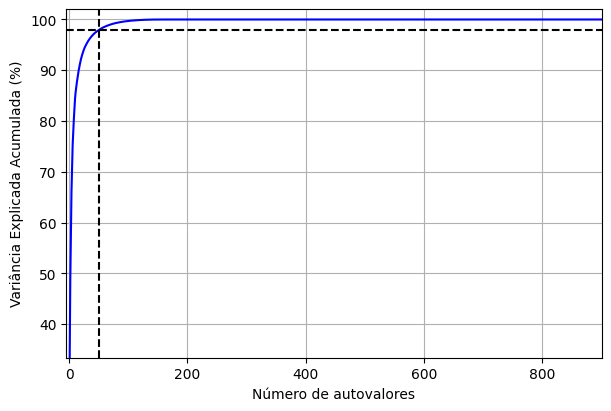

In [4]:
graphic_ve_cum(ve_cum=ve_cum, threshold=threshold, new_q=new_q)

# **Atividade 4**

Para todos atributos $x_{values}$ foi aplicado a função `pcacov` sem a redunção de dimensionalidade (adotou-se $q = 900$, correspondendo às 30x30 *features*). O conjunto transformado (`pca_x_values`) foi então avaliado nos mesmos classificadores da Atividade 2, preservando exatamente os mesmos parâmetros de entrada/hiperparâmetros de cada modelo.

## **Classificador Linear de Mínimos Quadrados (MQ)**

In [17]:
_ = linear_classifier(x_values=pca_x_values.T, y_values=y_values, 
    training_data_rate=0.8, number_simulations=50, verbose=True)

================ RESULTADOS - MQ ================
Média:  97.21% | Mediana:  96.97%
Mínimo:  90.91% | Máximo: 100.00%
Desvio Padrão:   2.83
Tempo: 1.92 s


## **Perceptron Logístico (PL)**

In [42]:
_ = perceptron_logistic_classifier(x_values=pca_x_values.T, y_values=y_values, 
    number_neurons=number_individuos, training_data_rate=0.8, number_of_rounds=50, 
    epoch_numbers=10, learning_rate=0.01, verbose=True)

================ RESULTADOS - PL ================
Média:  83.58% | Mediana:  86.36%
Mínimo:  48.48% | Máximo:  96.97%
Desvio Padrão:  11.86
Tempo: 2.95 s


## **Perceptron Multicamadas com uma camada (MLP-1H)**

In [46]:
_ = mlp_sigmoid_classifier(x_values=pca_x_values.T, y_values=y_values, 
    number_neurons=number_individuos, number_hidden_neurons=90, training_data_rate=0.8, 
    number_of_rounds=50, epoch_numbers=10, learning_rate=0.01, verbose=True)

================ RESULTADOS - MLP-1H(Sigmoid) ================
Média:  37.21% | Mediana:  36.36%
Mínimo:  15.15% | Máximo:  63.64%
Desvio Padrão:  10.37
Tempo: 15.76 s


## **Perceptron Multicamadas com duas camadas (MLP-2H)**

In [52]:
_ = mlp_tanh_classifier_2h(x_values=pca_x_values.T, y_values=y_values, 
    number_neurons=number_individuos, number_hidden_neurons=90, 
    number_hidden_neurons2=30, training_data_rate=0.8, number_of_rounds=50, 
    epoch_numbers=10, learning_rate=0.01, verbose=True)

================ RESULTADOS - MLP-2H(Tanh) ================
Média:  69.88% | Mediana:  71.21%
Mínimo:  48.48% | Máximo:  90.91%
Desvio Padrão:   9.82
Tempo: 20.06 s


## **Comentário**

Na Atividade 2, os atributos de entrada dos modelos PL e MLP (1H/2H) foram normalizados com z-score. Já nesta etapa, após aplicar PCA sem redução ($q=900$), testei normalizar os novos atributos (`pca_x_values`) com z-score, mas isso não trouxe os melhores resultados; por isso, mantive sem normalização.

Assim, ao aplicar PCA sem redução, o MQ manteve-se excelente e estável com a maior taxa de acerto ($97,21\%$), a menor variabilidade (desvio padrão de $2,83$), e ainda o menor tempo de $1,92$ s, confirmando sua baixa sensibilidade à escala das variáveis. Já o PL, os resultados obtidos foram intermediários já que apresenta uma taxa de acerto consideravél de $83,58\%$, mas com elevada variabilidade (com um desvio padrão de $11,86$) resultando em uma faixa ampla de valores de taxa de acerto (com o valor mínimo de $48,48\%$ e valor máximo de $96,97\%$). 

Para os modelos MLPs, foi obtidos os piores resultados com destaque para o MLP-1H (Sigmoid) que obtive a menor taxa de acerto médio e máximo (de $37,21\%$ e $63,64\%$, respectivamente) enquanto para o MLP-2H (Tanh), os resultados foram de $69,88\%$ para a taxa de acerto médio. Esses valores, sugere saturação das ativações e sensibilidade à faixa das primeiras componentes (que concentram grande parte da variância nas primeiras componentes).


| Modelo               | Média  | Mediana | Mínimo | Máximo  | Desvio Padrão | Tempo (s) |
|----------------------|--------|---------|--------|---------|----------------|-----------|
| **MQ**               | 97.21% | 96.97%  | 90.91% | 100.00% | 2.83           | 1.92      |
| **PL**               | 83.58% | 86.36%  | 48.48% | 96.97%  | 11.86          | 2.95      |
| **MLP-1H (Sigmoid)** | 37.21% | 36.36%  | 15.15% | 63.64%  | 10.37          | 15.76     |
| **MLP-2H (Tanh)**    | 69.88% | 71.21%  | 48.48% | 90.91%  | 9.82           | 20.06     |


Dessa forma, pode concluir que os atributos aplicado o PCA sem redução, o MQ manteve o melhor desempenho, mas para os demais modelos (PL e MLP) tiveram os piores resultados, um indicativo de uma forte dependência da faixa de valores dos parâmetros de entrada de tal maneira que seja compatíveis com as funções de ativações.

# **Atividade 5**

In [5]:
new_q = int((ve_cum <= 0.98).sum())
print(f"Para a variância explicada acumulada de 98%, temos q = {new_q}")

Para a variância explicada acumulada de 98%, temos q = 51


A partir do gráfico da variância explicada acumulada (na Atividade 3), obtemos $q = 51$ tal que $\mathrm{ve}_{\mathrm{cum}}(k) = 98\%$. Ou seja, podemos reduzir de $900$ atributos para $51$ ($\approx 94,33\%$ de redução dimensional) preservando $98\%$ da variância dos dados. 

# **Atividade 6**

Com $q = 51$, foi aplicado o PCA com redunção de dimensionalidade na função `pcacov`: 

In [6]:
_, pcaq_x_values = pcacov(value=x_values, value_q=new_q)
print(f"pcaq_x_values: {pcaq_x_values.shape}")

pcaq_x_values: (51, 165)


## **Classificador Linear de Mínimos Quadrados (MQ)**

In [15]:
_ = linear_classifier(x_values=pcaq_x_values.T, y_values=y_values, 
    training_data_rate=0.8, number_simulations=50, verbose=True)

================ RESULTADOS - MQ ================
Média:  96.30% | Mediana:  96.97%
Mínimo:  84.85% | Máximo: 100.00%
Desvio Padrão:   3.22
Tempo: 0.13 s


## **Perceptron Logístico (PL)**

In [56]:
pcaq_normz_x_values = normalize_zscore(pcaq_x_values)
_ = perceptron_logistic_classifier(x_values=pcaq_normz_x_values.T, y_values=y_values, 
    number_neurons=number_individuos, training_data_rate=0.8, number_of_rounds=50, 
    epoch_numbers=10, learning_rate=0.01, verbose=True)

================ RESULTADOS - PL ================
Média:  94.97% | Mediana:  93.94%
Mínimo:  87.88% | Máximo: 100.00%
Desvio Padrão:   3.24
Tempo: 1.41 s


## **Perceptron Multicamadas com uma camada (MLP-1H)**

In [58]:
_ = mlp_sigmoid_classifier(x_values=pcaq_normz_x_values.T, y_values=y_values, 
    number_neurons=number_individuos, number_hidden_neurons=90, training_data_rate=0.8, 
    number_of_rounds=50, epoch_numbers=10, learning_rate=0.01, verbose=True)

================ RESULTADOS - MLP-1H(Sigmoid) ================
Média:  70.42% | Mediana:  69.70%
Mínimo:  51.52% | Máximo:  90.91%
Desvio Padrão:   9.14
Tempo: 4.23 s


## **Perceptron Multicamadas com duas camadas (MLP-2H)**

In [57]:
_ = mlp_tanh_classifier_2h(x_values=pcaq_normz_x_values.T, y_values=y_values, 
    number_neurons=number_individuos, number_hidden_neurons=90, 
    number_hidden_neurons2=30, training_data_rate=0.8, number_of_rounds=50, 
    epoch_numbers=10, learning_rate=0.01, verbose=True)

================ RESULTADOS - MLP-2H(Tanh) ================
Média:  90.36% | Mediana:  90.91%
Mínimo:  63.64% | Máximo: 100.00%
Desvio Padrão:   6.98
Tempo: 8.35 s


## **Comentário**

A aplicação do PCA com redução de dimensionalidade ($q=51$), os novos parâmetros foi `pcaq_x_values` foram aplicados para os mesmos modelos da Atividade 2, em que para o MQ os parâmetros de entrada não foram normalizados quanto para o PL e MLP foram normalizados com z-score. Vale destacar que tanto a aplicação do PCA quando a normalização z-score foi aplicado sobre todos os dados. 

Os resultados confirmam a superioridade do MQ, que obteve a maior taxa de acerto médio ($96,30\%$) e o menor tempo ($0,13$ s). Em comparação às Atividades 2 e 4, há uma leve queda na taxa de acerto médio e aumento da variabilidade (devio padrão subiu de $2,8$ para $3,22$), compensados por um ganho expressivo de tempo graças à redução de dimensão. O PL se aproximou do MQ, com $94,97\%$ de acerto e um desvio padrão de $3,24$, a um tempo de $1,41$ s. Entre os modelos MLP, a MLP-2H (tanh) atingiu $90,36\%$, porém segue abaixo do desempenho do MQ e PL e com maior custo de tempo ($8,35$ s). Já a MLP-1H (sigmoid) melhorou em relação à Atividade 4, mas permaneceu com o pior desempenho desta etapa ($70,42\%$, e um desvio padrão de $9,14$).

| Modelo               | Média  | Mediana | Mínimo | Máximo  | Desvio Padrão | Tempo (s) |
|----------------------|--------|---------|--------|---------|----------------|-----------|
| **MQ**               | 96.30% | 96.97%  | 84.85% | 100.00% | 3.22           | 0.13      |
| **PL**               | 94.97% | 93.94%  | 87.88% | 100.00% | 3.24           | 1.41      |
| **MLP-1H (Sigmoid)** | 70.42% | 69.70%  | 51.52% | 90.91%  | 9.14           | 4.23      |
| **MLP-2H (Tanh)**    | 90.36% | 90.91%  | 63.64% | 100.00% | 6.98           | 8.35      |

A redução para  $q=51$ entregou grande ganho de tempo (especialmente no MQ) com pequena perda na taxa de acerto. O PL tornou-se um forte competidor ao combinar PCA reduzido + z-score. As MLPs melhoraram frente ao cenário da Atividade 4, mas continuam mais sensíveis à escala. 

# **Atividade 7**

A transformação Box-Cox seve para reduzir a assimetria, estabilizar variância e aproximar a distribuição de cada atributo de uma normal, o que costuma facilitar o treinamento (especialmente modelos lineares e otimizados por gradiente). Para $x > 0$, temos que: 

$$
y_{\lambda}(x)=
\begin{cases}
\dfrac{x^{\lambda}-1}{\lambda}, & \lambda \neq 0,\\[6pt]
\ln x, & \lambda = 0.
\end{cases}
$$

A transformação do Box-Cox foi aplicada aos dados transformados com redução de dimensiondalidade após a aplicação do PCA. E em seguida, foi aplicado a normalização z-score aos atributos. Dessa maneira, o pré-proocessamento dos atributos segue os seguintes passos: 

- Aplicação do PCA com redução de dimensionalidade
- Aplicação da transformada de box-cox com $\lambda = 1$
- Normalização z-score aos atributos

Após o processamento, o novos atributos foram aplicados para os mesmos modelos da Atividade 2.

In [80]:
new_x_values = normalize_zscore(box_cox_transformation(pcaq_x_values, lamb=1))

## **Classificador Linear de Mínimos Quadrados (MQ)**

In [81]:
_ = linear_classifier(x_values=new_x_values.T, y_values=y_values, 
    training_data_rate=0.8, number_simulations=50, verbose=True)

================ RESULTADOS - MQ ================
Média:  95.09% | Mediana:  93.94%
Mínimo:  87.88% | Máximo: 100.00%
Desvio Padrão:   3.42
Tempo: 0.13 s


## **Perceptron Logístico (PL)**

In [82]:
_ = perceptron_logistic_classifier(x_values=new_x_values.T, y_values=y_values, 
    number_neurons=number_individuos, training_data_rate=0.8, number_of_rounds=50, 
    epoch_numbers=10, learning_rate=0.01, verbose=True)

================ RESULTADOS - PL ================
Média:  95.58% | Mediana:  96.97%
Mínimo:  87.88% | Máximo: 100.00%
Desvio Padrão:   3.44
Tempo: 1.62 s


## **Perceptron Multicamadas com uma camada (MLP-1H)**

In [87]:
_ = mlp_sigmoid_classifier(x_values=new_x_values.T, y_values=y_values, 
    number_neurons=number_individuos, number_hidden_neurons=90, training_data_rate=0.8, 
    number_of_rounds=50, epoch_numbers=10, learning_rate=0.01, verbose=True)

================ RESULTADOS - MLP-1H(Sigmoid) ================
Média:  71.15% | Mediana:  72.73%
Mínimo:  54.55% | Máximo:  84.85%
Desvio Padrão:   7.91
Tempo: 4.26 s


## **Perceptron Multicamadas com duas camadas (MLP-2H)**

In [88]:
_ = mlp_tanh_classifier_2h(x_values=new_x_values.T, y_values=y_values, 
    number_neurons=number_individuos, number_hidden_neurons=90, 
    number_hidden_neurons2=30, training_data_rate=0.8, number_of_rounds=50, 
    epoch_numbers=10, learning_rate=0.01, verbose=True)

================ RESULTADOS - MLP-2H(Tanh) ================
Média:  90.24% | Mediana:  90.91%
Mínimo:  81.82% | Máximo: 100.00%
Desvio Padrão:   4.21
Tempo: 8.19 s


## **Comentário**

Com a aplicação da transformação Box-Cox, seguida da normaliação z-score, os resultados do PL apresentou maior taxa de acerto médio ($95,58\%$) a um custo de uma maior variablidade (com um desvio padrão de $3,44$) e tempo de execução ($1,62$ s) quando comparado com o desempenho do MQ, o qual apresentou o menor tempo de execução de $0,13$ s e um desvio padrão de $3,42$. Esse resultado é decorrente da transformação box-cox que reduz a assimetria entre os dados, mas também pode distorcer as relações lineares resultando em um pequeno declinio no resultado do MQ.

Já em relação aos modelos MLP, o MLP-2H (Tanh) manteve a taxa de acerto médio próximo de $90\%$, que foi o resultado obtido na Atividade 6, mas ficou mais estável com um desvio padrão de $4,21$ e um tempo de execução menor. E o MLP-1H (Sigmoid), teve um aumento nas métricas da taxa de acerto, de $70,42\%$ a $71,15\%$ para o valor médio em relação a Atividade 6, e um redução na variabilidade com desvio padrão de $7,91$. Mas quando comparando com os outros modelos nesta atividade, os resultados do MLP-1H e MLP-2H foram inferior do que o MQ e PL. 


| Modelo               | Média  | Mediana | Mínimo | Máximo  | Desvio Padrão | Tempo (s) |
|----------------------|--------|---------|--------|---------|----------------|-----------|
| **MQ**               | 95.09% | 93.94%  | 87.88% | 100.00% | 3.42           | 0.13      |
| **PL**               | 95.58% | 96.97%  | 87.88% | 100.00% | 3.44           | 1.62      |
| **MLP-1H (Sigmoid)** | 71.15% | 72.73%  | 54.55% | 84.85%  | 7.91           | 4.26      |
| **MLP-2H (Tanh)**    | 90.24% | 90.91%  | 81.82% | 100.00% | 4.21           | 8.19      |

Assim, com esses resultados podemos concluir que a transformação Box-Cox com a normalização z-score melhorou o resultado do PL, mas também estabilizou o resultado do MLP-2H (Tanh). Enquanto, o MQ segue o mais rápido mas com uma leve queda na taxa de acerto.


# **Atividade 8**

Partindo dos classificadores da Atividade 2, avaliamos controle de acesso combinando o conjunto de 15 indivíduos autorizados com 11 imagens de intrusos (matrizes `x_variable` e `y_variable`, esta última com 16 classes: 15 conhecidos + 1 “intruso”). Em seguida aplicamos o fluxo:

1. PCA com redução até $\approx 98\%$ de variância explicada.
2. Box–Cox por atributo com $\lambda = 1$.
3. Normalização z-score dos atributos transformados.

Após esse pré-processamento, treinamos e testamos os mesmos classificadores para medir acurácia, taxa de falsos positivos (intruso aceito), taxa de falsos negativos (autorizado barrado), sensibilidade e precisão, reportando médias e desvios-padrão em 50 rodadas.

In [3]:
x_variable = []
for index in range(11): 
    file = "intruso0"+str(index+1) if index < 9 else "intruso"+str(index+1) 
    img = read_image(path="image/", file=file+".jpeg")
    img = img.resize((30, 30))
            
    A = np.asarray(img, dtype=np.float64) / 255.0
    a = A.flatten(order="F") 
    x_variable.append(a)
    
x_variable = np.concatenate([x_values, np.array(x_variable).T], axis=1) 

y_known_ext = np.hstack([y_values, np.zeros((y_values.shape[0], 1))])
y_intr = np.zeros((11, y_values.shape[1] + 1))
y_intr[:, -1] = 1.0
y_variable = np.vstack([y_known_ext, y_intr]) 

print("x_variable", x_variable.shape, "y_variable", y_variable.shape)

x_variable (900, 176) y_variable (176, 16)


In [4]:
ve_cum, pca_x_variable = pcacov(value=x_variable, value_q=900)

threshold = 0.98
new_q_x_variable = int((ve_cum <= threshold).sum())
print(f"Para a variância explicada acumulada de 98%, temos q = {new_q_x_variable}")

Para a variância explicada acumulada de 98%, temos q = 54


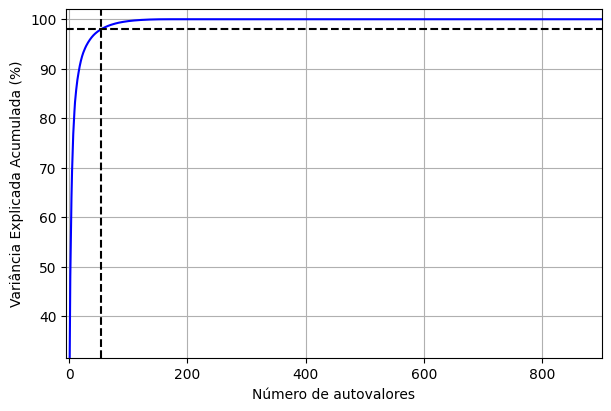

In [5]:
graphic_ve_cum(ve_cum=ve_cum, threshold=threshold, new_q=new_q_x_variable)

In [6]:
_, pcaq_x_variable = pcacov(value=x_variable, value_q=new_q_x_variable)
new_x_variable = normalize_zscore(box_cox_transformation(pcaq_x_variable, lamb=1))

In [ ]:
def summarize_metrics(metrics):
    keys = metrics[0].keys()

    for key in keys:
        values = np.array([res[key] for res in metrics if isinstance(res[key], (int, float))])
        if values.size == 0:
            continue

        print(f"\n{key}:")
        print(f"  Média: {np.mean(values):.4f} | Mínimo: {np.min(values):.4f} | Máximo: {np.max(values):.4f}")
        print(f"  Mediana: {np.median(values):.4f} | Variância: {np.var(values, ddof=1):.4f} | Desvio-Padrão: {np.std(values, ddof=1):.4f}")

## **Classificador Linear de Mínimos Quadrados (MQ)**

In [8]:
metrics_mq = linear_classifier(x_values=new_x_variable.T, y_values=y_variable, 
    training_data_rate=0.8, number_simulations=50, verbose=True, bool_metrics=True, intruder_idx=15)

summarize_metrics(metrics_mq)

================ RESULTADOS - MQ ================
Média:  95.39% | Mediana:  97.22%
Mínimo:  77.78% | Máximo: 100.00%
Desvio Padrão:   4.36
Tempo: 0.16 s

Acurácia:
  Média: 0.9944 | Mínimo: 0.8333 | Máximo: 1.0000
  Mediana: 1.0000 | Variância: 0.0006 | Desvio-Padrão: 0.0245

Taxa de Falsos Positivos:
  Média: 0.0567 | Mínimo: 0.0000 | Máximo: 1.0000
  Mediana: 0.0000 | Variância: 0.0358 | Desvio-Padrão: 0.1893

Taxa de Falsos Negativos:
  Média: 0.0000 | Mínimo: 0.0000 | Máximo: 0.0000
  Mediana: 0.0000 | Variância: 0.0000 | Desvio-Padrão: 0.0000

Precisão:
  Média: 0.9941 | Mínimo: 0.8182 | Máximo: 1.0000
  Mediana: 1.0000 | Variância: 0.0007 | Desvio-Padrão: 0.0266

Sensibilidade:
  Média: 1.0000 | Mínimo: 1.0000 | Máximo: 1.0000
  Mediana: 1.0000 | Variância: 0.0000 | Desvio-Padrão: 0.0000


## **Perceptron Logístico (PL)**

In [12]:
metrics_pl = perceptron_logistic_classifier(x_values=new_x_variable.T, 
    y_values=y_variable, number_neurons=16, training_data_rate=0.8, 
    number_of_rounds=50, epoch_numbers=10, learning_rate=0.01, 
    verbose=True, bool_metrics=True, intruder_idx=15)

summarize_metrics(metrics_pl)

================ RESULTADOS - PL ================
Média:  96.11% | Mediana:  97.22%
Mínimo:  86.11% | Máximo: 100.00%
Desvio Padrão:   3.33
Tempo: 1.50 s

Acurácia:
  Média: 0.9944 | Mínimo: 0.9444 | Máximo: 1.0000
  Mediana: 1.0000 | Variância: 0.0002 | Desvio-Padrão: 0.0125

Taxa de Falsos Positivos:
  Média: 0.0883 | Mínimo: 0.0000 | Máximo: 1.0000
  Mediana: 0.0000 | Variância: 0.0517 | Desvio-Padrão: 0.2274

Taxa de Falsos Negativos:
  Média: 0.0000 | Mínimo: 0.0000 | Máximo: 0.0000
  Mediana: 0.0000 | Variância: 0.0000 | Desvio-Padrão: 0.0000

Precisão:
  Média: 0.9941 | Mínimo: 0.9412 | Máximo: 1.0000
  Mediana: 1.0000 | Variância: 0.0002 | Desvio-Padrão: 0.0133

Sensibilidade:
  Média: 1.0000 | Mínimo: 1.0000 | Máximo: 1.0000
  Mediana: 1.0000 | Variância: 0.0000 | Desvio-Padrão: 0.0000


## **Perceptron Multicamadas com uma camada (MLP-1H)**

In [14]:
metrics_mlp1h = mlp_sigmoid_classifier(x_values=new_x_variable.T, y_values=y_variable, 
    number_neurons=16, number_hidden_neurons=90, training_data_rate=0.8, number_of_rounds=50, 
    epoch_numbers=10, learning_rate=0.01, verbose=True, bool_metrics=True, intruder_idx=15)

summarize_metrics(metrics_mlp1h)

================ RESULTADOS - MLP-1H(Sigmoid) ================
Média:  70.44% | Mediana:  70.83%
Mínimo:  52.78% | Máximo:  86.11%
Desvio Padrão:   7.55
Tempo: 4.63 s

Acurácia:
  Média: 0.9678 | Mínimo: 0.8889 | Máximo: 1.0000
  Mediana: 0.9722 | Variância: 0.0008 | Desvio-Padrão: 0.0283

Taxa de Falsos Positivos:
  Média: 0.3487 | Mínimo: 0.0000 | Máximo: 1.0000
  Mediana: 0.3333 | Variância: 0.1177 | Desvio-Padrão: 0.3431

Taxa de Falsos Negativos:
  Média: 0.0081 | Mínimo: 0.0000 | Máximo: 0.0571
  Mediana: 0.0000 | Variância: 0.0002 | Desvio-Padrão: 0.0144

Precisão:
  Média: 0.9745 | Mínimo: 0.9118 | Máximo: 1.0000
  Mediana: 0.9714 | Variância: 0.0007 | Desvio-Padrão: 0.0266

Sensibilidade:
  Média: 0.9919 | Mínimo: 0.9429 | Máximo: 1.0000
  Mediana: 1.0000 | Variância: 0.0002 | Desvio-Padrão: 0.0144


## **Perceptron Multicamadas com duas camadas (MLP-2H)**

In [16]:
metrics_mlp2h = mlp_tanh_classifier_2h(x_values=new_x_variable.T, y_values=y_variable, 
    number_neurons=16, number_hidden_neurons=90, number_hidden_neurons2=30, training_data_rate=0.8, 
    number_of_rounds=50, epoch_numbers=10, learning_rate=0.01, verbose=True, bool_metrics=True, intruder_idx=15)

summarize_metrics(metrics_mlp2h)

================ RESULTADOS - MLP-2H(Tanh) ================
Média:  90.00% | Mediana:  91.67%
Mínimo:  80.56% | Máximo: 100.00%
Desvio Padrão:   4.97
Tempo: 8.38 s

Acurácia:
  Média: 0.9911 | Mínimo: 0.9444 | Máximo: 1.0000
  Mediana: 1.0000 | Variância: 0.0002 | Desvio-Padrão: 0.0153

Taxa de Falsos Positivos:
  Média: 0.1133 | Mínimo: 0.0000 | Máximo: 1.0000
  Mediana: 0.0000 | Variância: 0.0595 | Desvio-Padrão: 0.2438

Taxa de Falsos Negativos:
  Média: 0.0018 | Mínimo: 0.0000 | Máximo: 0.0303
  Mediana: 0.0000 | Variância: 0.0001 | Desvio-Padrão: 0.0072

Precisão:
  Média: 0.9925 | Mínimo: 0.9412 | Máximo: 1.0000
  Mediana: 1.0000 | Variância: 0.0002 | Desvio-Padrão: 0.0152

Sensibilidade:
  Média: 0.9982 | Mínimo: 0.9697 | Máximo: 1.0000
  Mediana: 1.0000 | Variância: 0.0001 | Desvio-Padrão: 0.0072


## **Comentários**

Considerando a decisão binária, para classificar se o inidividuo é autorizado ou intruso na aplicação de controle de acesso, temos que os modelos MQ e PL apresentaram o melhor desempenho, ambos  com a acurácia de $99,44\%$. Em termos de estabilidade, o PL apresentou um menor desvio padrão ($1,25$), sendo o modelo mais estavél ao longo das rodadas. Já os modelo MLP, apresentaram desempenho inferior em relação ao MQ e PL, e ainda assim, a MLP-2H (tanh) superou a MLP-1H (sigmoid) em acurácia e estabilidade. Além disso, vale destacar que o MLP-2H (Tanh) apresentou uma menor variabilidade quando comparando com o MQ, ficando atrás somente do PL.

### Acurácia
| Modelo               | Média   | Mediana | Mínimo  | Máximo  | Desvio Padrão |
|----------------------|---------|---------|---------|---------|----------------|
| **MQ**               | 99.44%  | 100.00% | 83.33%  | 100.00% | 2.45%          |
| **PL**               | 99.44%  | 100.00% | 94.44%  | 100.00% | 1.25%          |
| **MLP-1H (Sigmoid)** | 96.78%  | 97.22%  | 88.89%  | 100.00% | 2.83%          |
| **MLP-2H (Tanh)**    | 99.11%  | 100.00% | 94.44%  | 100.00% | 1.53%          |

Quanto à taxa de falsos positivos (intrusos aceitos), o MQ teve o menor valor médio ($5,67\%$), seguido por PL ($8,83\%$) e MLP-2H ($11,33\%$), e por último, a MLP-1H ficou bem acima ($34,87\%$). A mediana $0\%$ na maioria dos modelos indica que, na maior parte das rodadas, nenhum intruso é aceito, porém, o máximo em $100\%$ revela piores-casos ocasionais (esperados quando há poucas amostras de intrusos no teste), esse feito pode ser ocasionado por uma divisão aleatória em que não acontece uma divisão equilibrada entre amostras de intrusos e uma solução para isto, é utilizar uma divisão estratificada.

### Taxa de Falsos Positivos (intrusos aceitos)
| Modelo               | Média  | Mediana | Mínimo | Máximo  | Desvio Padrão |
|----------------------|--------|---------|--------|---------|----------------|
| **MQ**               | 5.67%  | 0.00%   | 0.00%  | 100.00% | 18.93%         |
| **PL**               | 8.83%  | 0.00%   | 0.00%  | 100.00% | 22.74%         |
| **MLP-1H (Sigmoid)** | 34.87% | 33.33%  | 0.00%  | 100.00% | 34.31%         |
| **MLP-2H (Tanh)**    | 11.33% | 0.00%   | 0.00%  | 100.00% | 24.38%         |

Já em relação a taxa de falsos negativos (autorizados barrados), o MQ e PL tiveram uma taxa de $0\%$ em todas rodadas, ou seja, nenhum autorizado foi barrado. Entre as MLPs, a MLP-2H ficou bem próxima disso ($0,18\%$ em média, raros erros), enquanto a MLP-1H foi o pior ($0,81\%$, com piores-casos de $5,71\%$). 

### Taxa de Falsos Negativos (autorizados barrados)
| Modelo               | Média | Mediana | Mínimo | Máximo | Desvio Padrão |
|----------------------|-------|---------|--------|--------|----------------|
| **MQ**               | 0.00% | 0.00%   | 0.00%  | 0.00%  | 0.00%          |
| **PL**               | 0.00% | 0.00%   | 0.00%  | 0.00%  | 0.00%          |
| **MLP-1H (Sigmoid)** | 0.81% | 0.00%   | 0.00%  | 5.71%  | 1.44%          |
| **MLP-2H (Tanh)**    | 0.18% | 0.00%   | 0.00%  | 3.03%  | 0.72%          |

Em termos de precisão, isto é, entre os que o modelo autorizou, qual proporção era de fato autorizado, temos que o MQ e PL obtiveram $99,41\%$, seguidos de perto pela MLP-2H ($99,25\%$) e o pior resultado foi o do MLP-1H, como ($97,45\%$). Em termos de estabilidade, tem que o PL apresenta o menor devio padrão de $1,33$, seguido do MLP-2H com $1,52$, enquanto MQ e MLP-1H empacatados com desvio padrão de $2,66$. 

### Precisão (para autorizados)
| Modelo               | Média   | Mediana | Mínimo  | Máximo  | Desvio Padrão |
|----------------------|---------|---------|---------|---------|----------------|
| **MQ**               | 99.41%  | 100.00% | 90.91%  | 100.00% | 2.66%          |
| **PL**               | 99.41%  | 100.00% | 94.12%  | 100.00% | 1.33%          |
| **MLP-1H (Sigmoid)** | 97.45%  | 97.14%  | 91.18%  | 100.00% | 2.66%          |
| **MLP-2H (Tanh)**    | 99.25%  | 100.00% | 94.12%  | 100.00% | 1.52%          |

Já a sensiblidade, proporção de autorizados corretamente liberado, o MQ e PL atingem $100\%$ (com um desvio padrão de $0\%$), ou seja, ninguém autorizado foi barrado pelo sistema. A sensiblidade do MLP-2H apresentou um resultado próximo com $99,82\%$ e MLP-1H um pouco abaixo ($99,19\%$), ambas com baixa variabilidade.

### Sensibilidade (TPR para autorizados)
| Modelo               | Média   | Mediana | Mínimo  | Máximo  | Desvio Padrão |
|----------------------|---------|---------|---------|---------|----------------|
| **MQ**               | 100.00% | 100.00% | 100.00% | 100.00% | 0.00%          |
| **PL**               | 100.00% | 100.00% | 100.00% | 100.00% | 0.00%          |
| **MLP-1H (Sigmoid)** | 99.19%  | 100.00% | 94.29%  | 100.00% | 1.44%          |
| **MLP-2H (Tanh)**    | 99.82%  | 100.00% | 96.97%  | 100.00% | 0.72%          |
